#### Parsing the Netlist
-adding the circuit id to enable the graph classification

Each row in all_circuits_features_graphclass.csv has a circuit_id column equal to the filename (minus the “.v”), which you can use to group nodes into graphs for your graph‐classification experiments.

In [1]:
import os
import re
import networkx as nx
import pandas as pd
from networkx.exception import NetworkXNoPath

def parse_verilog_netlist(verilog_file):
    G = nx.DiGraph()
    gate_types = ['and','or','nand','nor','xor','xnor','buf','not']
    gates = {}
    all_signals = set()
    output_signals = set()
    input_signals = set()

    with open(verilog_file,'r') as f:
        lines = f.readlines()

    gate_pattern = re.compile(rf'\s*({"|".join(gate_types)})\s+(\w+)\s*\((.*)\);')
    for i,line in enumerate(lines):
        if i%1000==0:
            print(f"Parsing line {i}/{len(lines)}")
        m = gate_pattern.match(line.strip())
        if not m: 
            continue
        gate_type, gate_name, conn = m.groups()
        sigs = [s.strip() for s in conn.split(',')]
        out = sigs[0]
        ins = sigs[1:]
        input_signals.update(ins)
        output_signals.add(out)
        all_signals.update(sigs)
        gates[out] = (gate_name, gate_type, ins)
        G.add_node(gate_name, type=gate_type)

    # identify PIs/POs
    primary_inputs  = input_signals - output_signals
    primary_outputs = output_signals - input_signals

    # wire up edges
    for out,(gname,_,ins) in gates.items():
        for inp in ins:
            if inp in gates:
                G.add_edge(gates[inp][0], gname)
            elif inp in primary_inputs:
                # treat PI as a node
                G.add_node(inp, type='input')
                G.add_edge(inp, gname)

    # ensure all POs get a node
    for po in primary_outputs:
        G.add_node(po, type='output')
        if po in gates:
            G.add_edge(gates[po][0], po)

    return G, gates, primary_inputs, primary_outputs

def extract_features(G, gates, primary_inputs, primary_outputs, circuit_id):
    """
    circuit_id: base filename without .v
    """
    import networkx as nx
    features = []
    deg_cent  = nx.degree_centrality(G)
    btw_cent  = nx.betweenness_centrality(G, k=min(100,len(G)))
    clo_cent  = nx.closeness_centrality(G)
    clust_coef= nx.clustering(G)

    for node in G.nodes:
        node_type = G.nodes[node]['type']
        is_pi      = int(node in primary_inputs)
        is_po      = int(node in primary_outputs)
        is_int     = int(not (is_pi or is_po))
        fan_in     = G.in_degree(node)
        fan_out    = G.out_degree(node)
        nbrs       = list(G.neighbors(node))
        avg_fi_nbr = sum(G.in_degree(n) for n in nbrs)/len(nbrs) if nbrs else 0
        avg_fo_nbr = sum(G.out_degree(n) for n in nbrs)/len(nbrs) if nbrs else 0

        # depth (distance from any PI)
        try:
            if is_pi:
                depth = 0
            else:
                depths = [nx.shortest_path_length(G, source=pi, target=node)
                          for pi in primary_inputs if nx.has_path(G, pi, node)]
                depth = min(depths) if depths else -1
        except (NetworkXNoPath, KeyError):
            depth = -1

        # dist to any PO
        try:
            if is_po:
                dist_out = 0
            else:
                ds = [nx.shortest_path_length(G, source=node, target=po)
                      for po in primary_outputs if nx.has_path(G, node, po)]
                dist_out = min(ds) if ds else -1
        except (NetworkXNoPath, ValueError):
            dist_out = -1

        is_key = int(node_type in ['xor','xnor'])
        features.append({
            'circuit_id': circuit_id,          # <-- new column
            'node': node,
            'gate_type': node_type,
            'fan_in': fan_in,
            'fan_out': fan_out,
            'depth': depth,
            'dist_to_output': dist_out,
            'is_primary_input': is_pi,
            'is_primary_output': is_po,
            'is_internal': is_int,
            'is_key_gate': is_key,
            'degree_centrality': deg_cent.get(node,0),
            'betweenness_centrality': btw_cent.get(node,0),
            'closeness_centrality': clo_cent.get(node,0),
            'clustering_coefficient': clust_coef.get(node,0),
            'avg_fan_in_neighbors': avg_fi_nbr,
            'avg_fan_out_neighbors': avg_fo_nbr
        })
    return pd.DataFrame(features)


def process_all_netlists(folder_path):
    all_feats = []
    for fname in os.listdir(folder_path):
        if not fname.endswith('.v'):
            continue
        path = os.path.join(folder_path, fname)
        print(f"→ processing {fname}")
        circuit_id = os.path.splitext(fname)[0]     # strip “.v”
        try:
            G, gates, pis, pos = parse_verilog_netlist(path)
            feats = extract_features(G, gates, pis, pos, circuit_id)
            all_feats.append(feats)
        except Exception as e:
            print(f"⚠️ {fname} skipped: {e}")

    if all_feats:
        df_all = pd.concat(all_feats, ignore_index=True)
        df_all.to_csv("all_circuits_features_graphclass.csv", index=False)
        print("✅ saved all_circuits_features.csv")
    else:
        print("❌ no features extracted.")

if __name__=="__main__":
    process_all_netlists("verilog_benchmark_circuits-master")


→ processing adder.v
Parsing line 0/2595
Parsing line 1000/2595
Parsing line 2000/2595
→ processing arbiter.v
Parsing line 0/26540
Parsing line 1000/26540
Parsing line 2000/26540
Parsing line 3000/26540
Parsing line 4000/26540
Parsing line 5000/26540
Parsing line 6000/26540
Parsing line 7000/26540
Parsing line 8000/26540
Parsing line 9000/26540
Parsing line 10000/26540
Parsing line 11000/26540
Parsing line 12000/26540
Parsing line 13000/26540
Parsing line 14000/26540
Parsing line 15000/26540
Parsing line 16000/26540
Parsing line 17000/26540
Parsing line 18000/26540
Parsing line 19000/26540
Parsing line 20000/26540
Parsing line 21000/26540
Parsing line 22000/26540
Parsing line 23000/26540
Parsing line 24000/26540
Parsing line 25000/26540
Parsing line 26000/26540
→ processing bar.v
Parsing line 0/3479
Parsing line 1000/3479
Parsing line 2000/3479
Parsing line 3000/3479
→ processing c1355.v
Parsing line 0/610
→ processing c17.v
Parsing line 0/20
→ processing c1908.v
Parsing line 0/565
→ p

##### Display and describe the content of all_circuits_features_graphclass.csv.

In [3]:
import pandas as pd

# Load the extracted features CSV file
df = pd.read_csv("all_circuits_features_graphclass.csv")

# Display the first few rows
print("\n🔹 First 5 rows of the DataFrame:")
print(df.head())

# Summary statistics
print("\n🔹 DataFrame Summary:")
print(df.info())

print("\n🔹 Statistical Summary:")
print(df.describe())

# Check for missing values
print("\n🔹 Missing Values in Each Column:")
print(df.isnull().sum())

# Count the number of circuits processed
num_circuits = df['circuit_id'].nunique()
num_nodes = df.shape[0]
print(f"\n✅ Number of circuits processed: {num_circuits}")
print(f"✅ Total number of nodes (gates + inputs/outputs): {num_nodes}")

# Count of different gate types
print("\n🔹 Gate Type Distribution:")
print(df['gate_type'].value_counts())

# Check the number of key gates detected
num_key_gates = df['is_key_gate'].sum()
print(f"\n🔑 Number of detected key gates: {num_key_gates}")



🔹 First 5 rows of the DataFrame:
  circuit_id node gate_type  fan_in  fan_out  depth  dist_to_output  \
0      adder   g1       not       1        1      1               3   
1      adder   g2       and       2        1      1               2   
2      adder   g3       not       1        1      1               3   
3      adder   g4       and       2        1      1               2   
4      adder   g5        or       2        1      2               1   

   is_primary_input  is_primary_output  is_internal  is_key_gate  \
0                 0                  0            1            0   
1                 0                  0            1            0   
2                 0                  0            1            0   
3                 0                  0            1            0   
4                 0                  0            1            0   

   degree_centrality  betweenness_centrality  closeness_centrality  \
0           0.000786                     0.0              0.

#### Parameter Regularization: EWC

What are the tasks? 
- We want four successive binary problems, each asking “Is this circuit in size-quartile q or not?” for q=0,1,2,3. 
- Quartile 0: the smallest 25% of your circuits by node-count. 
- Quartile 1: next 25% (25–50% smallest). 
- Quartile 2: next 25% (50–75%). 
- Quartile 3: largest 25% (75–100%).

Concretely, at Task 1 you train a GCN to separate the 0th-quartile circuits (positive class) from all others (negative class). At Task 2, you freeze in the EWC sense and train to separate 1st-quartile vs rest, and so on through Task 4.

How did we create them?
- After parsing the CSV and building one DGL graph per circuit_id, we computed the number of nodes in each graph.
- We took those counts and found the 25th, 50th, and 75th percentiles.
- Each graph got a quartile label 0–3 via np.digitize(node_counts, quartile_thresholds).
- For each quartile q, we gathered the indices of all graphs with label==q (positives) and label≠q (negatives).
- We then split those positives/negatives into an 80/20 train/test stratified split.


=== Stage 1: quartile 0 vs rest ===
  Epoch 01, loss: 0.6817
  Epoch 10, loss: 0.6787
  Epoch 50, loss: 0.6757
  → Acc task1: 83.33%


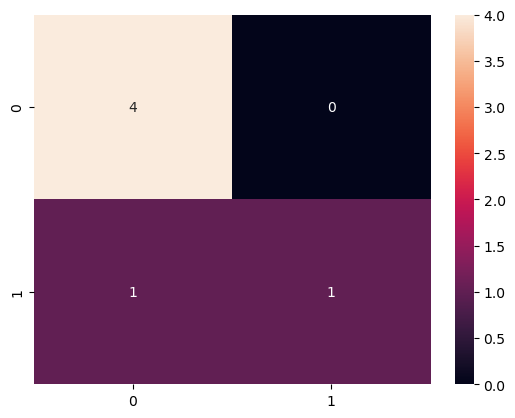


=== Stage 2: quartile 1 vs rest ===
  Epoch 01, loss: 0.6929
  Epoch 10, loss: 0.6818
  Epoch 50, loss: 0.6701
  → Acc task1: 66.67%


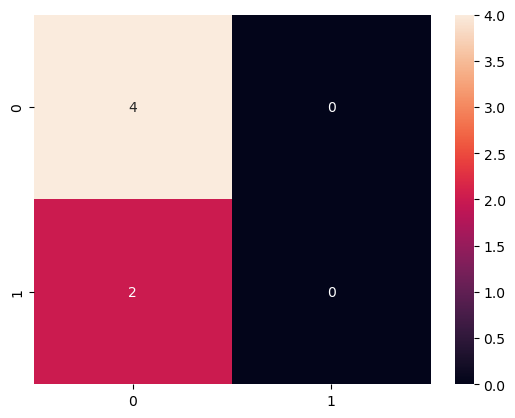

  → Acc task2: 80.00%


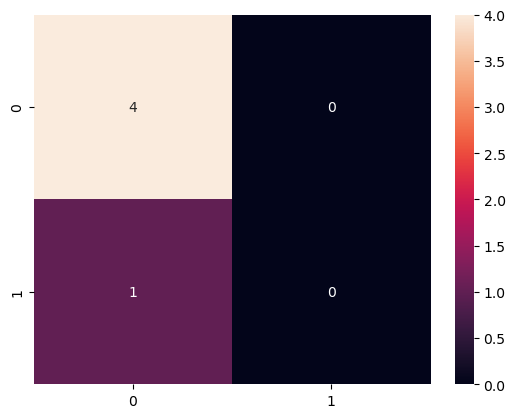


=== Stage 3: quartile 2 vs rest ===
  Epoch 01, loss: 0.6545
  Epoch 10, loss: 0.6453
  Epoch 50, loss: 0.6382
  → Acc task1: 66.67%


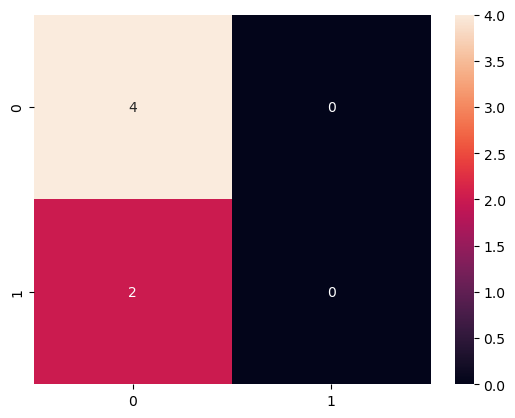

  → Acc task2: 80.00%


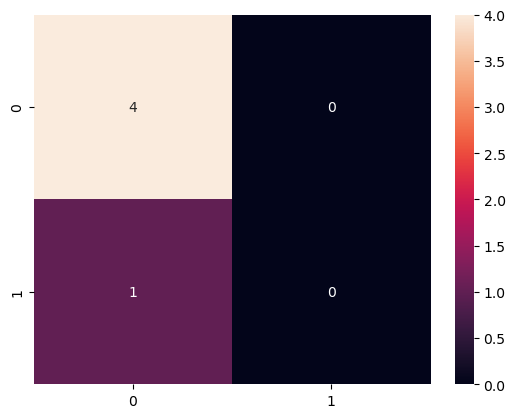

  → Acc task3: 66.67%


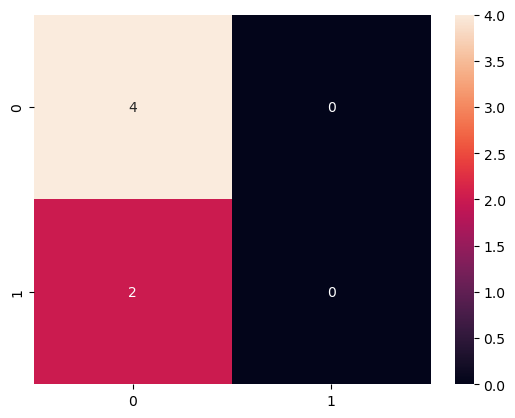


=== Stage 4: quartile 3 vs rest ===
  Epoch 01, loss: 0.6322
  Epoch 10, loss: 0.6276
  Epoch 50, loss: 0.6238
  → Acc task1: 66.67%


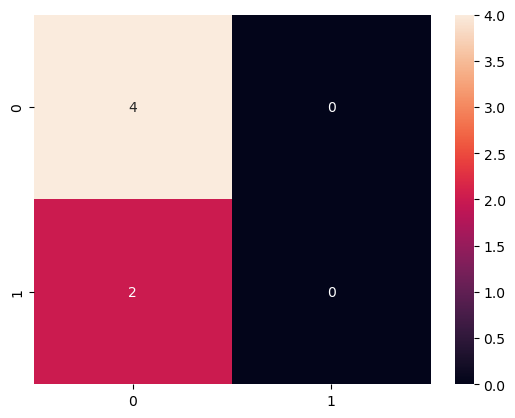

  → Acc task2: 80.00%


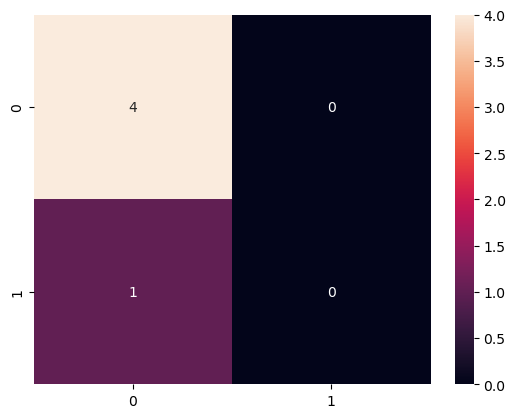

  → Acc task3: 66.67%


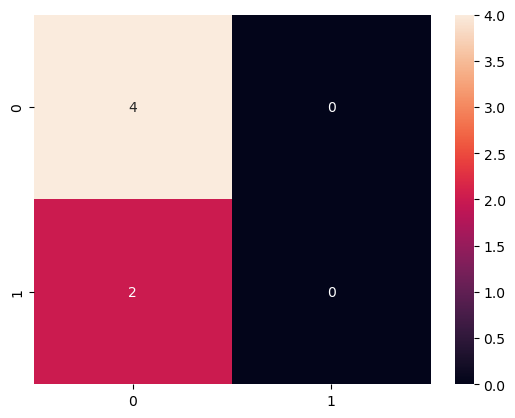

  → Acc task4: 66.67%


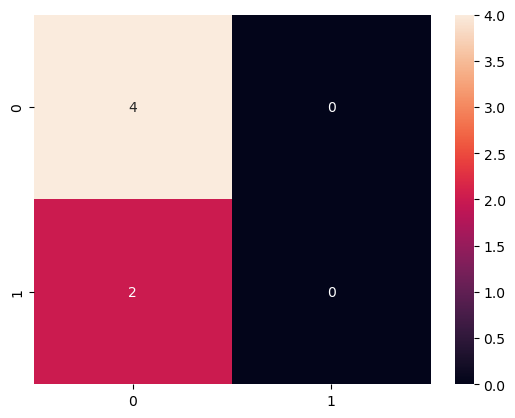

       task_1  task_2  task_3  task_4
Stage                                
1      83.33%    nan%    nan%    nan%
2      66.67%  80.00%    nan%    nan%
3      66.67%  80.00%  66.67%    nan%
4      66.67%  80.00%  66.67%  66.67%
  from_to        pd        ed        da
0     1→2  0.148259  0.000006  0.166667
1     1→3  0.302645  0.000017  0.166667
2     2→3  0.160192  0.000001  0.000000
3     1→4  0.457295  0.000025  0.166667
4     2→4  0.319695  0.000004  0.000000
5     3→4  0.161410  0.000001  0.000000
Corr(pd vs da): 0.3940667540923494
Corr(ed vs da): 0.7726696732237125


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load & preprocess
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# 2) Build one graph per circuit_id
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges: continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values, dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# quartile labels 0–3
qs = np.percentile(sizes, [25,50,75])
quarts = np.digitize(sizes, qs)  # each graph’s quartile

# 3) Four binary tasks: quartile q vs rest
tasks = []
for q in range(4):
    pos = np.where(quarts==q)[0]
    neg = np.where(quarts!=q)[0]
    tasks.append((pos, neg))

# 4) GCN + EWC helper
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.c1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.c2 = dglnn.GraphConv(hid, hid,   allow_zero_in_degree=True)
        self.read = nn.Linear(hid, 2)

    def forward(self, g, x):
        h = torch.relu(self.c1(g, x))
        h = torch.relu(self.c2(g, h))
        hg= h.mean(dim=0, keepdim=True)
        return self.read(hg)

class EWC:
    def __init__(self, model, graphs, task_pos, device):
        self.device = device
        # save params
        self.params = {n:p.clone().detach().to(device)
                       for n,p in model.named_parameters()}
        # init fisher
        self.fisher = {n:torch.zeros_like(p,device=device)
                       for n,p in model.named_parameters()}
        model.eval()
        # compute on train positives
        for i in task_pos:
            g = graphs[i].to(device)
            out = model(g, g.ndata["feat"].to(device))
            logp= nn.functional.log_softmax(out, dim=1)[0,1]
            model.zero_grad(); logp.backward()
            for n,p in model.named_parameters():
                self.fisher[n] += p.grad.detach()**2
        # normalize
        for n in self.fisher:
            self.fisher[n] /= len(task_pos)

    def penalty(self, model):
        loss=0
        for n,p in model.named_parameters():
            loss += (self.fisher[n] * (p-self.params[n])**2).sum()
        return loss

# 5) Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCNEnc(len(feat_cols), hid=64).to(device)
opt    = optim.Adam(model.parameters(), lr=1e-3)
lambda_ewc=500.0
ewc_list=[]
results   = {}
param_snaps=[]

for stage,(pos,neg) in enumerate(tasks, start=1):
    print(f"\n=== Stage {stage}: quartile {stage-1} vs rest ===")
    # split train/test
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    train_idx = np.concatenate([p_tr, n_tr])
    train_lbl = torch.tensor(
        [1]*len(p_tr)+[0]*len(n_tr), dtype=torch.long, device=device
    )

    # train
    model.train()
    for epoch in (1,10,50):
        opt.zero_grad()
        outs=[]
        for i in train_idx:
            g=graphs[i].to(device)
            outs.append(model(g, g.ndata["feat"].to(device))[0])
        outs = torch.stack(outs)
        loss = nn.CrossEntropyLoss()(outs, train_lbl)
        if ewc_list:
            loss += (lambda_ewc/2)*sum(e.penalty(model) for e in ewc_list)
        loss.backward(); opt.step()
        print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # snapshot & fisher
    ewc_list.append(EWC(model, graphs, p_tr, device))
    param_snaps.append({n:p.clone().detach().cpu()
                        for n,p in model.state_dict().items()})

    # evaluate all seen tasks
    model.eval()
    with torch.no_grad():
        logits = [model(g.to(device), g.ndata["feat"].to(device))[0].cpu().numpy()
                  for g in graphs]
    logits = np.vstack(logits)
    preds  = logits.argmax(axis=1)

    results[stage]={}
    for k in range(stage):
        pos_k, neg_k = tasks[k]
        _,pte_k = train_test_split(pos_k, test_size=0.2, random_state=42)
        _,nte_k = train_test_split(neg_k, test_size=0.2, random_state=42)
        idxs = np.concatenate([pte_k, nte_k])
        lbls = np.concatenate([np.ones(len(pte_k)), np.zeros(len(nte_k))])
        prd  = preds[idxs]
        acc  = accuracy_score(lbls, prd)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1}: {acc*100:.2f}%")
        cm=confusion_matrix(lbls, prd)
        sns.heatmap(cm,annot=True,fmt="d"); plt.show()

# summary
df_res=pd.DataFrame(results).T
df_res.index.name="Stage"
print(df_res.applymap(lambda x:f"{x*100:.2f}%"))

# dashboard
records=[]
for t in range(2,len(param_snaps)+1):
    θ_t=param_snaps[t-1]
    for k in range(1,t):
        θ_k=param_snaps[k-1]
        # param drift
        pd2=sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd_=np.sqrt(pd2)
        # ewc drift
        Fk=ewc_list[k-1].fisher
        ed=sum((Fk[n].cpu()*(θ_t[n]-θ_k[n])**2).sum().item() for n in θ_k)
        # forgetting
        da=results[k][f"task_{k}"]-results[t][f"task_{k}"]
        records.append({"from":k,"to":t,"pd":pd_,"ed":ed,"da":da})

dash=pd.DataFrame(records)
dash["from_to"]=dash["from"].astype(str)+"→"+dash["to"].astype(str)
print(dash[["from_to","pd","ed","da"]])
print("Corr(pd vs da):",dash.pd.corr(dash.da))
print("Corr(ed vs da):",dash.ed.corr(dash.da))


#### Parameter Regularization: SI


=== Stage 1: quartile 0 vs rest ===
  Epoch 01, loss: 0.6504
  Epoch 10, loss: 0.6467
  Epoch 50, loss: 0.6430
  → Acc task1 after stage1: 83.33%


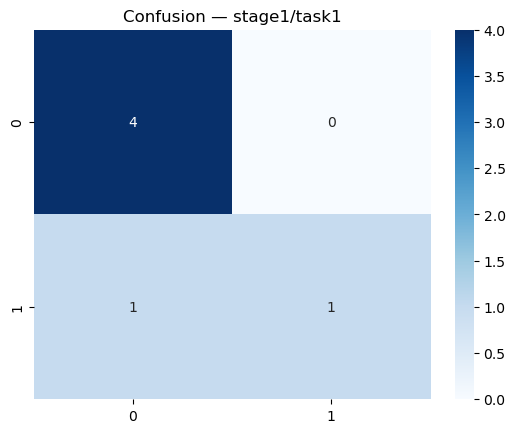


=== Stage 2: quartile 1 vs rest ===
  Epoch 01, loss: 0.7292
  Epoch 10, loss: 0.7090
  Epoch 50, loss: 0.6844
  → Acc task1 after stage2: 83.33%


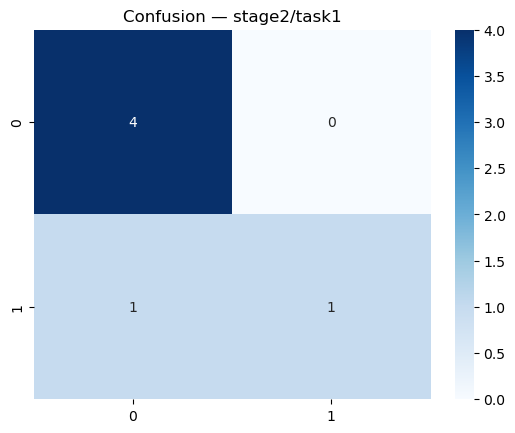

  → Acc task2 after stage2: 80.00%


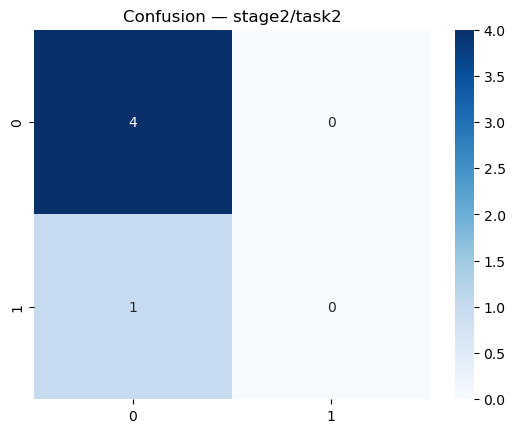


=== Stage 3: quartile 2 vs rest ===
  Epoch 01, loss: 0.6668
  Epoch 10, loss: 0.6440
  Epoch 50, loss: 0.6263
  → Acc task1 after stage3: 66.67%


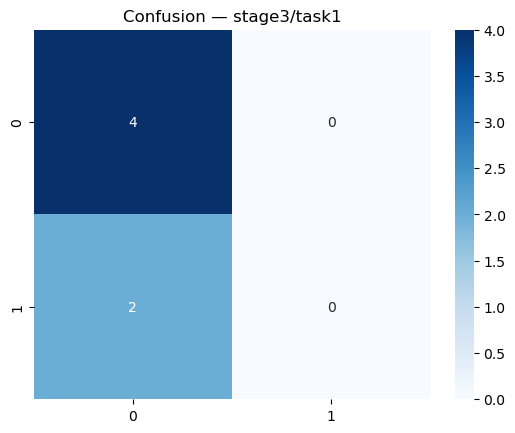

  → Acc task2 after stage3: 80.00%


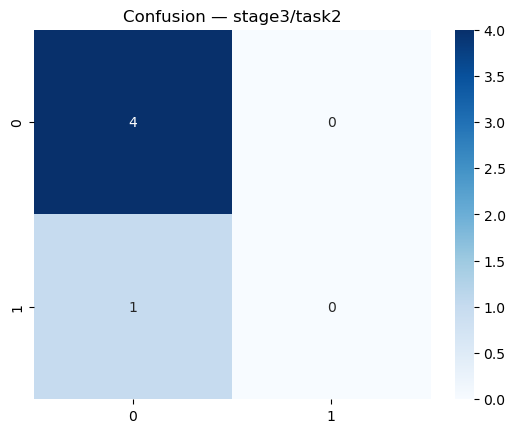

  → Acc task3 after stage3: 66.67%


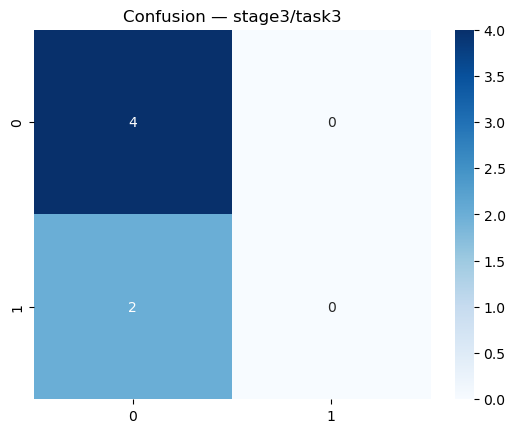


=== Stage 4: quartile 3 vs rest ===
  Epoch 01, loss: 0.6094
  Epoch 10, loss: 0.5993
  Epoch 50, loss: 0.5928
  → Acc task1 after stage4: 66.67%


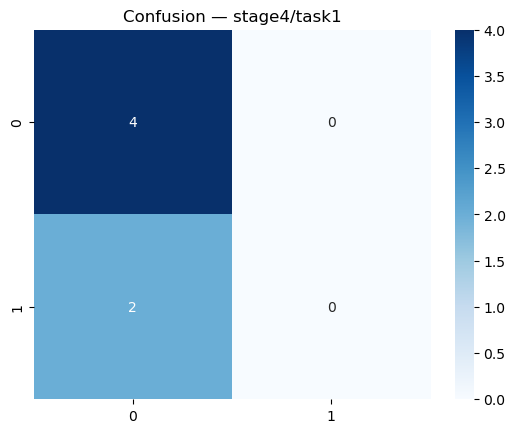

  → Acc task2 after stage4: 80.00%


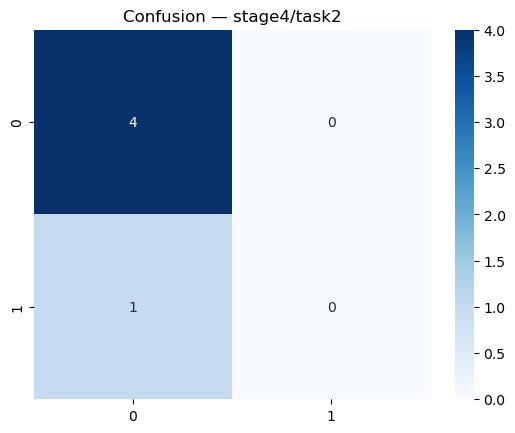

  → Acc task3 after stage4: 66.67%


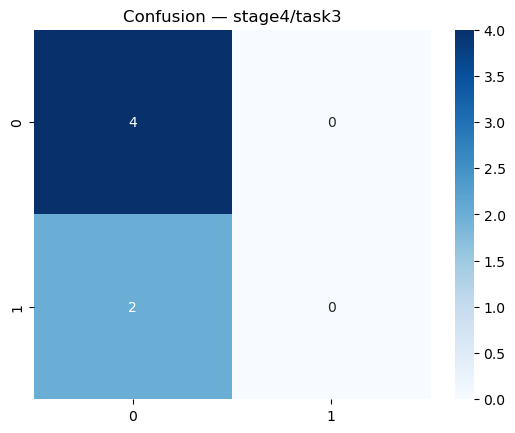

  → Acc task4 after stage4: 66.67%


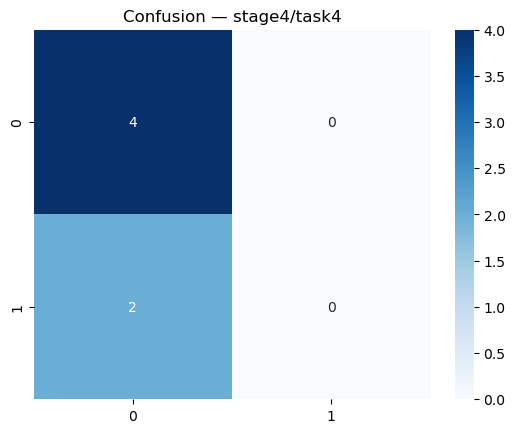


=== Accuracies per stage & task ===
       task_1  task_2  task_3  task_4
Stage                                
1      83.33%    nan%    nan%    nan%
2      83.33%  80.00%    nan%    nan%
3      66.67%  80.00%  66.67%    nan%
4      66.67%  80.00%  66.67%  66.67%

=== SI Dashboard: Drift vs Forgetting ===
  from_to  param_drift      si_drift  delta_acc
0     1→2     0.150303  3.557388e-07   0.000000
1     1→3     0.303091  1.568814e-06   0.166667
2     2→3     0.159126  3.254309e-06   0.000000
3     1→4     0.448460  3.625209e-06   0.166667
4     2→4     0.309821  1.203106e-05   0.000000
5     3→4     0.154001  4.799104e-06   0.000000
Corr(param drift vs ΔAcc): 0.7793
Corr(SI drift vs ΔAcc):    -0.3155


In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load & preprocess CSV
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# 2) Build one graph per circuit_id and record sizes
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        # take first k nodes as pseudo‐inputs
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges: continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values, dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# 3) Quartile labels 0–3
qs = np.percentile(sizes, [25,50,75])
labels = np.digitize(sizes, qs)  # each graph’s quartile

# 4) Build 4 binary tasks: quartile q vs rest, with 80/20 splits
tasks = []
for q in range(4):
    pos = np.where(labels==q)[0]
    neg = np.where(labels!=q)[0]
    if len(pos)<5:
        continue
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    tasks.append({
        "q": q,
        "train_pos": p_tr, "train_neg": n_tr,
        "test_pos":  p_te, "test_neg":  n_te
    })

# 5) GCN + readout
class GCNClassifier(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   hid,   allow_zero_in_degree=True)
        self.read  = nn.Linear(hid, 2)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        h = torch.relu(self.conv2(g, h))
        hg= h.mean(dim=0, keepdim=True)
        return self.read(hg)

# 6) Synaptic Intelligence (SI)
class SI:
    def __init__(self, model, xi=0.1):
        self.xi = xi
        self.omega = {n: torch.zeros_like(p) for n,p in model.named_parameters() if p.requires_grad}
        self.theta_old = {n: p.clone().detach() for n,p in model.named_parameters() if p.requires_grad}
    def begin_task(self, model):
        self.prev_theta = {n: p.clone().detach() for n,p in model.named_parameters() if p.requires_grad}
        self.path_omega = {n: torch.zeros_like(p) for n,p in model.named_parameters() if p.requires_grad}
    def accumulate(self, model):
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            grad  = p.grad.data
            delta = p.data - self.prev_theta[n]
            self.path_omega[n] += -grad * delta
            self.prev_theta[n] = p.data.clone().detach()
    def end_task(self, model):
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            delta = p.data - self.theta_old[n]
            denom = delta.pow(2) + self.xi
            omega_task = self.path_omega[n] / denom
            self.omega[n] += omega_task
            self.theta_old[n] = p.data.clone().detach()
    def penalty(self, model):
        loss = 0
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            loss += (self.omega[n] * (p - self.theta_old[n]).pow(2)).sum()
        return loss

# 7) Train w/ SI
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model       = GCNClassifier(len(feat_cols), hid=64).to(device)
opt         = optim.Adam(model.parameters(), lr=1e-3)
si          = SI(model, xi=0.1)
lambda_si   = 1000.0
results     = {}
theta_snaps = []
omega_snaps = []

for stage, t in enumerate(tasks, start=1):
    q = t["q"]
    print(f"\n=== Stage {stage}: quartile {q} vs rest ===")
    # prepare train sets
    P = t["train_pos"]; Nn = t["train_neg"]
    train_idxs = np.concatenate([P, Nn])
    y_tr = torch.tensor([1]*len(P)+[0]*len(Nn), dtype=torch.long, device=device)

    si.begin_task(model)
    model.train()
    for epoch in (1,10,50):
        opt.zero_grad()
        outs=[]
        for i in train_idxs:
            g = graphs[i].to(device)
            outs.append(model(g, g.ndata["feat"].to(device))[0])
        outs = torch.stack(outs)
        loss = nn.CrossEntropyLoss()(outs, y_tr)
        if stage>1:
            loss = loss + lambda_si * si.penalty(model)
        loss.backward()
        si.accumulate(model)
        opt.step()
        print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    si.end_task(model)
    # snapshots
    theta_snaps.append({n:p.clone().cpu() for n,p in model.named_parameters() if p.requires_grad})
    omega_snaps.append({n:v.clone().cpu() for n,v in si.omega.items()})

    # evaluate on all seen tasks
    model.eval()
    with torch.no_grad():
        logits = []
        for g in graphs:
            g = g.to(device)
            logits.append(model(g, g.ndata["feat"].to(device))[0].cpu().numpy())
        logits = np.vstack(logits)
        preds  = logits.argmax(axis=1)

    results[stage] = {}
    for k in range(stage):
        pos_k = tasks[k]["test_pos"]
        neg_k = tasks[k]["test_neg"]
        idxs = np.concatenate([pos_k, neg_k])
        y_true = np.concatenate([np.ones(len(pos_k)), np.zeros(len(neg_k))])
        y_pred = preds[idxs]
        acc = accuracy_score(y_true, y_pred)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1} after stage{stage}: {acc*100:.2f}%")
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion — stage{stage}/task{k+1}")
        plt.show()

# 8) Summary
df_res = pd.DataFrame(results).T
df_res.index.name="Stage"
print("\n=== Accuracies per stage & task ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# 9) Interpretability Dashboard
records=[]
for t in range(2, len(theta_snaps)+1):
    θ_t = theta_snaps[t-1]
    for k in range(1, t):
        θ_k = theta_snaps[k-1]
        Ω_k = omega_snaps[k-1]
        # param drift
        pd2 = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd_  = np.sqrt(pd2)
        # SI‐drift
        sid = sum((Ω_k[n] * (θ_t[n]-θ_k[n])**2).sum().item() for n in θ_k)
        # forgetting
        da  = results[k][f"task_{k}"] - results[t][f"task_{k}"]
        records.append({
            "from": k, "to": t,
            "param_drift": pd_,
            "si_drift":    sid,
            "delta_acc":   da
        })

dash = pd.DataFrame(records)
dash["from_to"] = dash["from"].astype(str)+"→"+dash["to"].astype(str)
print("\n=== SI Dashboard: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","si_drift","delta_acc"]])
print(f"Corr(param drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
print(f"Corr(SI drift vs ΔAcc):    {dash.si_drift.corr(dash.delta_acc):.4f}")


#### Replay-based Methods (a.k.a. Experience Replay):iCaRL (Incremental Classifier and Representation Learning)


=== Stage 1: quartile 0 vs rest ===
  Epoch 01, loss: 0.6680
  Epoch 15, loss: 0.6213
  Epoch 30, loss: 0.5527
  → Acc task1 after stage1: 100.00%


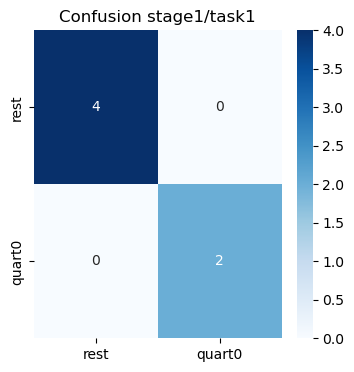


=== Stage 2: quartile 1 vs rest ===
  Epoch 01, loss: 1.0358
  Epoch 15, loss: 0.6044
  Epoch 30, loss: 0.5922
  → Acc task1 after stage2: 66.67%


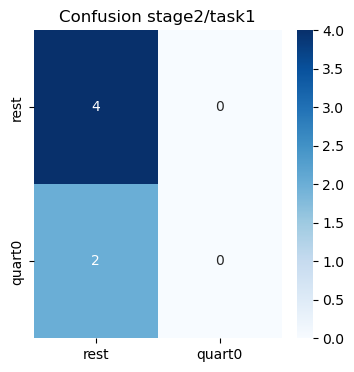

  → Acc task2 after stage2: 80.00%


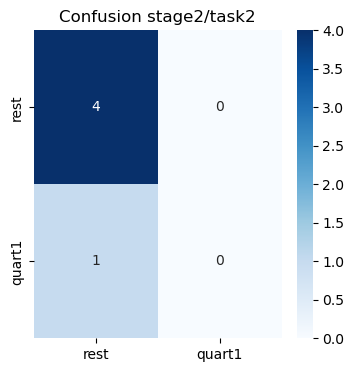


=== Stage 3: quartile 2 vs rest ===
  Epoch 01, loss: 0.5923
  Epoch 15, loss: 0.5635
  Epoch 30, loss: 0.5528
  → Acc task1 after stage3: 66.67%


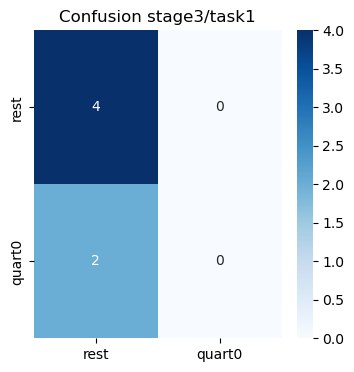

  → Acc task2 after stage3: 80.00%


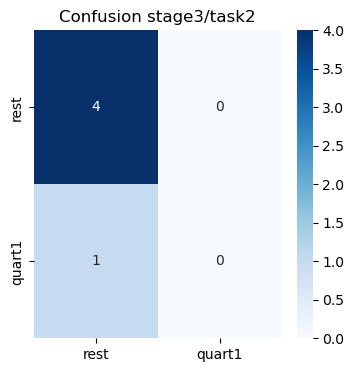

  → Acc task3 after stage3: 66.67%


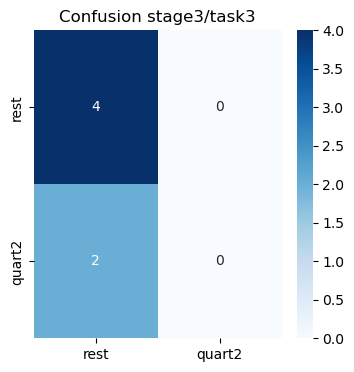


=== Stage 4: quartile 3 vs rest ===
  Epoch 01, loss: 0.5158
  Epoch 15, loss: 0.4991
  Epoch 30, loss: 0.4914
  → Acc task1 after stage4: 66.67%


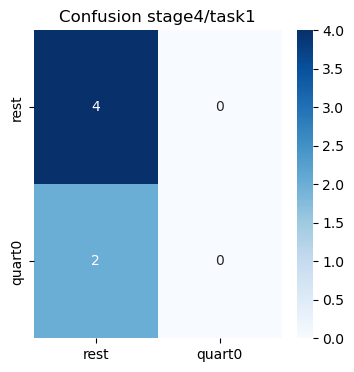

  → Acc task2 after stage4: 80.00%


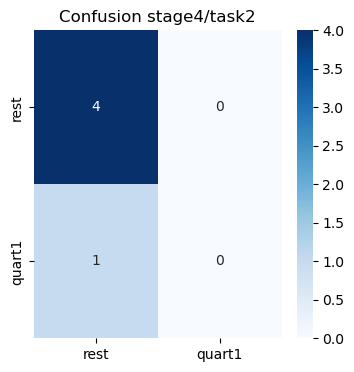

  → Acc task3 after stage4: 66.67%


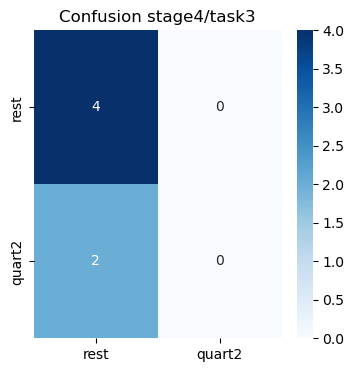

  → Acc task4 after stage4: 66.67%


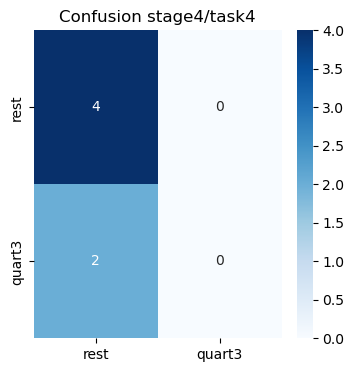


=== Accuracies per stage & task ===
        task_1  task_2  task_3  task_4
Stage                                 
1      100.00%    nan%    nan%    nan%
2       66.67%  80.00%    nan%    nan%
3       66.67%  80.00%  66.67%    nan%
4       66.67%  80.00%  66.67%  66.67%

=== iCaRL Dashboard: Drift vs Forgetting ===
  from_to  param_drift  distill_loss  delta_acc
0     1→2     1.198720      0.096607   0.333333
1     1→3     1.731123     35.113602   0.333333
2     2→3     0.949856      0.921750   0.000000
3     1→4     1.899203     55.708729   0.333333
4     2→4     1.380369      5.530960   0.000000
5     3→4     0.788789      1.880792   0.000000

Corr(param drift vs ΔAcc): 0.7193
Corr(distill loss vs ΔAcc): 0.6453


In [10]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load & preprocess CSV
# -------------------------------
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# -------------------------------
# 2. Build one DGLGraph per circuit
# -------------------------------
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges: 
        continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values, dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# -------------------------------
# 3. Four binary tasks: quartile q vs rest
# -------------------------------
qs = np.percentile(sizes, [25,50,75])
quarts = np.digitize(sizes, qs)  # 0..3
tasks = []
for q in range(4):
    pos = np.where(quarts==q)[0]
    neg = np.where(quarts!=q)[0]
    # train/test split
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    tasks.append({
        "q": q,
        "train_pos": p_tr, "train_neg": n_tr,
        "test_pos":  p_te, "test_neg":  n_te
    })

# -------------------------------
# 4. GCN + FC readout
# -------------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.c1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.c2 = dglnn.GraphConv(hid,   hid,   allow_zero_in_degree=True)
        self.read = nn.Linear(hid, 2)
    def forward(self, g, x):
        h = torch.relu(self.c1(g, x))
        h = torch.relu(self.c2(g, h))
        hg = h.mean(dim=0, keepdim=True)
        return self.read(hg)

# -------------------------------
# 5. iCaRL‐style memory + distillation
# -------------------------------
memory_per_class = 20
temperature      = 2.0
lambda_distill   = 1.0
kl_loss          = nn.KLDivLoss(reduction='batchmean')
exemplar_sets    = {0: [], 1: []}

def update_exemplars(label, new_idxs):
    """Keep at most memory_per_class exemplars per label."""
    np.random.shuffle(new_idxs)
    exemplar_sets[label] = new_idxs[:memory_per_class]

def get_all_exemplars():
    return exemplar_sets[0] + exemplar_sets[1]  # list of graph indices

# -------------------------------
# 6. Train w/ iCaRL
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCNEnc(len(feat_cols), 64).to(device)
opt    = optim.Adam(model.parameters(), lr=1e-3)
results = {}
param_snaps, logits_snaps, memory_snaps = [], [], []
old_model = None

for stage, t in enumerate(tasks, start=1):
    q      = t["q"]
    p_tr   = t["train_pos"].tolist()
    n_tr   = t["train_neg"].tolist()
    p_te   = t["test_pos"]
    n_te   = t["test_neg"]

    print(f"\n=== Stage {stage}: quartile {q} vs rest ===")

    # freeze old model for distillation
    if old_model:
        old_model.eval()

    # training set = new + exemplars
    new_idxs = p_tr + n_tr
    exem_idxs= get_all_exemplars()
    train_idxs = new_idxs + exem_idxs
    train_labels = torch.tensor(
        [1]*len(p_tr) + [0]*len(n_tr) + 
        [1 if i in exemplar_sets[1] else 0 for i in exem_idxs],
        dtype=torch.long, device=device
    )

    # precompute old soft targets
    if old_model and exem_idxs:
        with torch.no_grad():
            snaps = []
            for i in exem_idxs:
                g = graphs[i].to(device)
                snaps.append(old_model(g, g.ndata["feat"].to(device))[0])
            old_logits = torch.stack(snaps, dim=0)
            old_soft   = F.softmax(old_logits/temperature, dim=1)

    # train 30 epochs
    model.train()
    for epoch in range(1, 31):
        opt.zero_grad()
        outs = []
        for i in train_idxs:
            g = graphs[i].to(device)
            outs.append(model(g, g.ndata["feat"].to(device))[0])
        outs = torch.stack(outs, dim=0)

        ce = nn.CrossEntropyLoss()(outs, train_labels)
        if old_model and exem_idxs:
            new_logp = F.log_softmax(outs[-len(exem_idxs):]/temperature, dim=1)
            dist = kl_loss(new_logp, old_soft) * (temperature**2)
            loss = ce + lambda_distill * dist
        else:
            loss = ce

        loss.backward(); opt.step()
        if epoch in (1,15,30):
            print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # update exemplars for this binary task
    update_exemplars(1, p_tr)
    update_exemplars(0, n_tr)
    memory_snaps.append(get_all_exemplars())

    # snapshots
    param_snaps.append({n:p.clone().detach().cpu() for n,p in model.named_parameters()})
    with torch.no_grad():
        all_logits = []
        for g in graphs:
            g = g.to(device)
            all_logits.append(model(g, g.ndata["feat"].to(device))[0].cpu().numpy())
    logits_snaps.append(np.vstack(all_logits))

    # evaluate on all seen tasks
    model.eval()
    with torch.no_grad():
        all_preds = logits_snaps[-1].argmax(axis=1)

    results[stage] = {}
    for k in range(stage):
        tp = tasks[k]["test_pos"]
        tn = tasks[k]["test_neg"]
        idxs = np.concatenate([tp, tn])
        y_true = np.concatenate([np.ones(len(tp)), np.zeros(len(tn))])
        y_pred = all_preds[idxs]
        acc = accuracy_score(y_true, y_pred)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1} after stage{stage}: {acc*100:.2f}%")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["rest","quart"+str(tasks[k]["q"])],
                    yticklabels=["rest","quart"+str(tasks[k]["q"])])
        plt.title(f"Confusion stage{stage}/task{k+1}")
        plt.show()

    old_model = copy.deepcopy(model).eval().to(device)

# -------------------------------
# 7. Summary of accuracies
# -------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Accuracies per stage & task ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# -------------------------------
# 8. Interpretability Dashboard
# -------------------------------
records = []
num_t = len(param_snaps)
for t in range(2, num_t+1):
    θ_t = param_snaps[t-1]
    logits_t = logits_snaps[t-1]
    M_k = memory_snaps[t-2]  # memory after stage t-1
    for k in range(1, t):
        θ_k = param_snaps[k-1]
        logits_k = logits_snaps[k-1]

        # 1) param drift
        sq = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd_ = np.sqrt(sq)
        # 2) distill loss on M_k
        if M_k:
            diffs = logits_t[M_k] - logits_k[M_k]
            dl = np.mean(np.sum(diffs**2, axis=1))
        else:
            dl = np.nan
        # 3) forgetting ΔAcc
        da = results[k][f"task_{k}"] - results[t][f"task_{k}"]

        records.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": pd_,
            "distill_loss": dl,
            "delta_acc":   da
        })

dash = pd.DataFrame(records)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)
print("\n=== iCaRL Dashboard: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","distill_loss","delta_acc"]])
print(f"\nCorr(param drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
print(f"Corr(distill loss vs ΔAcc): {dash.distill_loss.corr(dash.delta_acc):.4f}")


#### Replay-based Methods (a.k.a. Experience Replay): A-GEM (Average Gradient Episodic Memory)


=== Stage 1: quartile 0 vs rest ===
  Epoch 01, loss_new: 0.7263
  Epoch 10, loss_new: 0.7227
  Epoch 50, loss_new: 0.7192
  → Acc task1: 33.33%


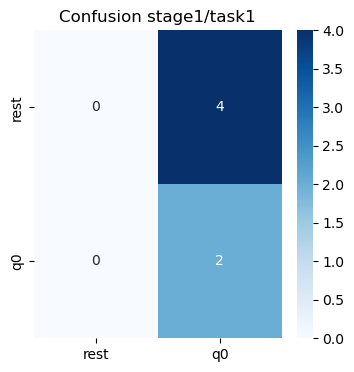


=== Stage 2: quartile 1 vs rest ===
  Epoch 01, loss_new: 0.8089
  Epoch 10, loss_new: 0.7819
  Epoch 50, loss_new: 0.7511
  → Acc task1: 16.67%


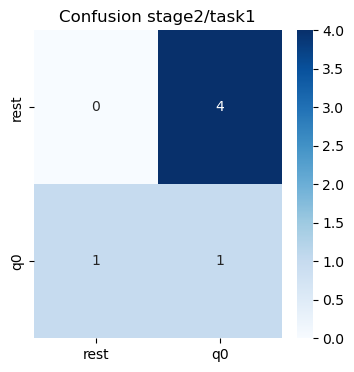

  → Acc task2: 20.00%


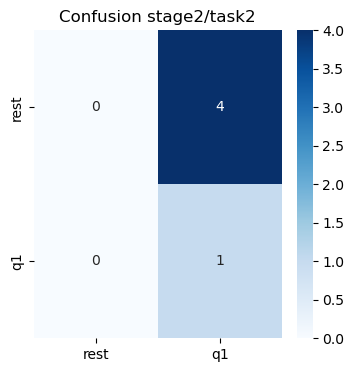


=== Stage 3: quartile 2 vs rest ===
  Epoch 01, loss_new: 0.7150
  Epoch 10, loss_new: 0.6912
  Epoch 50, loss_new: 0.6746
  → Acc task1: 0.00%


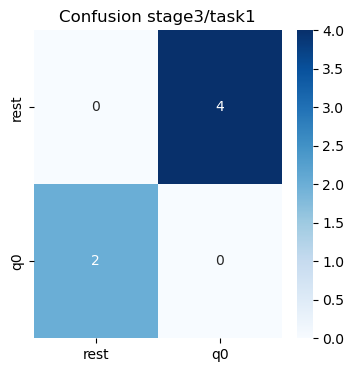

  → Acc task2: 20.00%


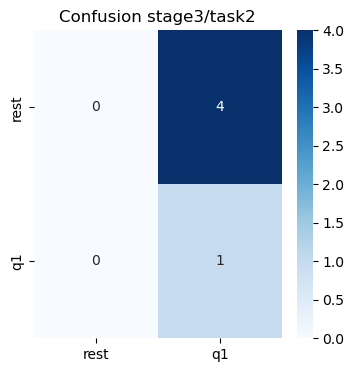

  → Acc task3: 33.33%


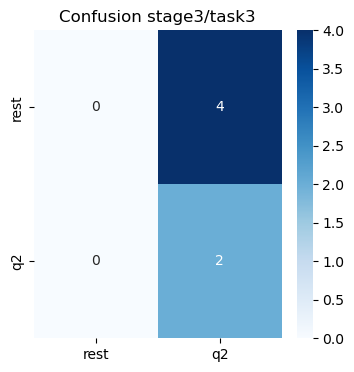


=== Stage 4: quartile 3 vs rest ===
  Epoch 01, loss_new: 0.6625
  Epoch 10, loss_new: 0.6539
  Epoch 50, loss_new: 0.6467
  → Acc task1: 16.67%


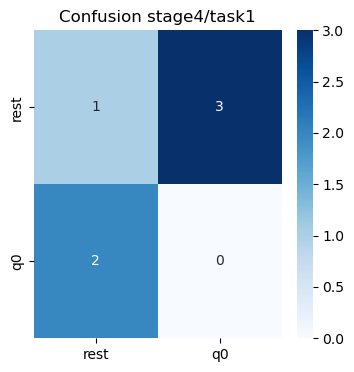

  → Acc task2: 20.00%


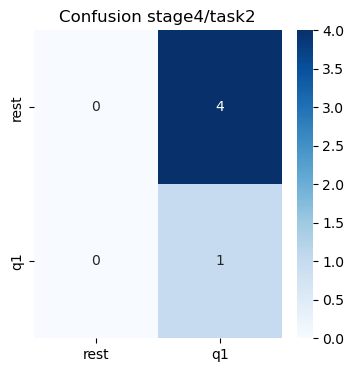

  → Acc task3: 50.00%


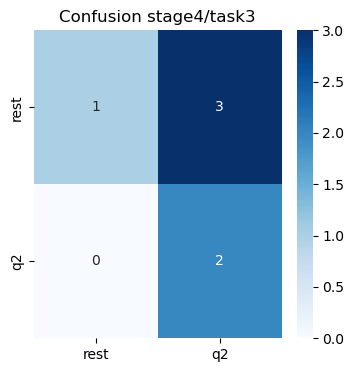

  → Acc task4: 50.00%


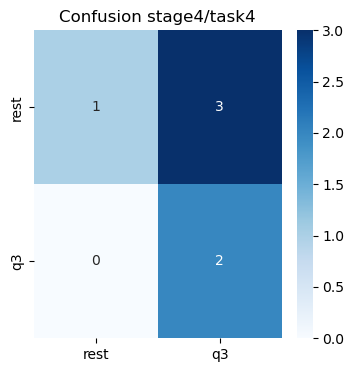


=== Accuracies per stage & task ===
       task_1  task_2  task_3  task_4
Stage                                
1      33.33%    nan%    nan%    nan%
2      16.67%  20.00%    nan%    nan%
3       0.00%  20.00%  33.33%    nan%
4      16.67%  20.00%  50.00%  50.00%


AttributeError: 'numpy.float64' object has no attribute 'DataFrame'

In [11]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. Load & preprocess CSV
# -------------------------
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# -------------------------
# 2. Build one graph per circuit
# -------------------------
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges: continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values, dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# -------------------------
# 3. Define 4 quartile tasks
# -------------------------
qs = np.percentile(sizes, [25,50,75])
quarts = np.digitize(sizes, qs)  # labels 0–3

tasks = []
for q in range(4):
    pos = np.where(quarts==q)[0]
    neg = np.where(quarts!=q)[0]
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    tasks.append({
        "q": q,
        "train_pos": p_tr.tolist(), "train_neg": n_tr.tolist(),
        "test_pos":  p_te.tolist(), "test_neg":  n_te.tolist()
    })

# -------------------------
# 4. GCN + readout
# -------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.c1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.c2 = dglnn.GraphConv(hid,   hid,   allow_zero_in_degree=True)
        self.read = nn.Linear(hid, 2)
    def forward(self, g, x):
        h = torch.relu(self.c1(g, x))
        h = torch.relu(self.c2(g, h))
        hg= h.mean(dim=0, keepdim=True)
        return self.read(hg)

# -------------------------
# 5. A-GEM helpers
# -------------------------
def get_grad_vector(params):
    return torch.cat([p.grad.view(-1) for p in params])

def set_grad_vector(params, vec):
    pointer = 0
    for p in params:
        numel = p.numel()
        p.grad.copy_(vec[pointer:pointer+numel].view_as(p))
        pointer += numel

# -------------------------
# 6. Train w/ A-GEM
# -------------------------
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model         = GCNEnc(len(feat_cols), hid=64).to(device)
opt           = optim.Adam(model.parameters(), lr=1e-3)
criterion     = nn.CrossEntropyLoss()

memory_buffer = []    # stored graph indices
memory_snaps  = []
param_snaps   = []
results       = {}

mem_batch_size  = 64
memory_per_task = 200

for stage, t in enumerate(tasks, start=1):
    q      = t["q"]
    p_tr   = t["train_pos"]; n_tr = t["train_neg"]
    p_te   = t["test_pos"];  n_te = t["test_neg"]
    new_idxs = p_tr + n_tr
    params   = [p for p in model.parameters() if p.requires_grad]

    print(f"\n=== Stage {stage}: quartile {q} vs rest ===")
    model.train()
    for epoch in (1,10,50):
        # 1) ref grad on memory
        if memory_buffer:
            mem_idxs = random.sample(memory_buffer,
                                     min(mem_batch_size, len(memory_buffer)))
            opt.zero_grad()
            outs_mem = []
            for i in mem_idxs:
                g = graphs[i].to(device)
                outs_mem.append(model(g, g.ndata["feat"].to(device))[0])
            outs_mem = torch.stack(outs_mem)
            # labels for mem examples
            y_mem = []
            for i in mem_idxs:
                for j in range(stage-1):
                    if i in tasks[j]["train_pos"]:
                        y_mem.append(1); break
                    if i in tasks[j]["train_neg"]:
                        y_mem.append(0); break
            y_mem = torch.tensor(y_mem, dtype=torch.long, device=device)
            loss_mem = criterion(outs_mem, y_mem)
            loss_mem.backward()
            g_ref = get_grad_vector(params).clone()

        # 2) grad on new task
        opt.zero_grad()
        outs_new = []
        for i in new_idxs:
            g = graphs[i].to(device)
            outs_new.append(model(g, g.ndata["feat"].to(device))[0])
        outs_new = torch.stack(outs_new)
        y_new = torch.tensor([1]*len(p_tr)+[0]*len(n_tr),
                              dtype=torch.long, device=device)
        loss_new = criterion(outs_new, y_new)
        loss_new.backward()
        g_new = get_grad_vector(params).clone()

        # 3) A-GEM projection
        if memory_buffer:
            dot = torch.dot(g_new, g_ref)
            if dot < 0:
                g_proj = g_new - dot / (g_ref.dot(g_ref)+1e-12) * g_ref
                set_grad_vector(params, g_proj)

        opt.step()
        print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory_buffer
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)
    memory_snaps.append(list(memory_buffer))

    # snapshot params
    param_snaps.append({n:p.clone().detach().cpu()
                        for n,p in model.state_dict().items()})

    # evaluation on all seen tasks
    model.eval()
    with torch.no_grad():
        all_logits = []
        for g in graphs:
            g = g.to(device)
            all_logits.append(model(g, g.ndata["feat"].to(device))[0].cpu().numpy())
        all_preds = np.vstack(all_logits).argmax(axis=1)

    results[stage] = {}
    for k in range(stage):
        tp = tasks[k]["test_pos"]; tn = tasks[k]["test_neg"]
        idxs = tp + tn
        y_true = np.array([1]*len(tp)+[0]*len(tn))
        y_pred = all_preds[idxs]
        acc = accuracy_score(y_true, y_pred)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1}: {acc*100:.2f}%")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["rest",f"q{tasks[k]['q']}"],
                    yticklabels=["rest",f"q{tasks[k]['q']}"])
        plt.title(f"Confusion stage{stage}/task{k+1}")
        plt.show()

# -------------------------
# 7. Summary of accuracies
# -------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Accuracies per stage & task ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# -------------------------
# 8. Interpretability Dashboard
# -------------------------
records = []
for t in range(2, len(param_snaps)+1):
    θ_t = param_snaps[t-1]
    for k in range(1, t):
        θ_k = param_snaps[k-1]
        # param drift
        pd2 = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd  = np.sqrt(pd2)
        # cosine sim of gradients
        # compute g_new_t
        model.zero_grad()
        outs = []
        for i in tasks[t-1]["train_pos"]+tasks[t-1]["train_neg"]:
            g = graphs[i].to(device)
            outs.append(model(g, g.ndata["feat"].to(device))[0])
        outs = torch.stack(outs)
        lbl = torch.tensor([1]*len(tasks[t-1]["train_pos"])+[0]*len(tasks[t-1]["train_neg"]),
                           device=device)
        loss_t = criterion(outs, lbl); loss_t.backward()
        g_new_t = get_grad_vector([p for p in model.parameters() if p.requires_grad]).cpu()
        # reference grad for task k
        model.zero_grad()
        mem_k = memory_snaps[k-1]
        outs_k = []
        for i in mem_k:
            g = graphs[i].to(device)
            outs_k.append(model(g, g.ndata["feat"].to(device))[0])
        if outs_k:
            outs_k = torch.stack(outs_k)
            lbl_k  = []
            for i in mem_k:
                if i in tasks[k-1]["train_pos"]: lbl_k.append(1)
                else: lbl_k.append(0)
            lbl_k = torch.tensor(lbl_k, device=device)
            loss_k = criterion(outs_k, lbl_k); loss_k.backward()
            g_ref_k = get_grad_vector([p for p in model.parameters() if p.requires_grad]).cpu()
            cos_sim = torch.dot(g_new_t, g_ref_k)/(g_new_t.norm()*g_ref_k.norm()+1e-12)
            cos_sim = cos_sim.item()
        else:
            cos_sim = np.nan

        # forgetting
        da = results[k][f"task_{k}"] - results[t][f"task_{k}"]

        records.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": pd,
            "cos_sim":     cos_sim,
            "delta_acc":   da
        })

dash = pd.DataFrame(records)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)
print("\n=== A-GEM Dashboard: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","cos_sim","delta_acc"]])
print(f"\nCorr(param_drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
print(f"Corr(cosine_sim vs ΔAcc):  {dash.cos_sim.corr(dash.delta_acc):.4f}")


In [12]:
# -----------------------------
# Interpretability Dashboard (fixed)
# -----------------------------
import pandas as _pd
import numpy as _np

# Sanity check
if not isinstance(records, list):
    raise RuntimeError(f"`records` must be a list, got {type(records)}")

# Build DataFrame
dash = _pd.DataFrame.from_records(records)

if dash.empty:
    print("Not enough data for A-GEM dashboard.")
else:
    # Create the "from→to" label
    dash["from_to"] = (
        dash["from_task"].astype(int).astype(str)
        + "→"
        + dash["to_task"].astype(int).astype(str)
    )

    # Print the dashboard
    print("\n=== A-GEM Dashboard: Drift vs Forgetting ===")
    print(dash[["from_to","param_drift","cos_sim","delta_acc"]])

    # Correlations
    corr_pd  = dash["param_drift"].corr(dash["delta_acc"])
    corr_cs  = dash["cos_sim"].corr(dash["delta_acc"])
    print(f"\nCorr(param_drift vs ΔAcc): {corr_pd:.4f}")
    print(f"Corr(cos_sim vs ΔAcc):       {corr_cs:.4f}")



=== A-GEM Dashboard: Drift vs Forgetting ===
  from_to  param_drift   cos_sim  delta_acc
0     1→2     0.153880  0.832518   0.166667
1     1→3     0.310674  0.725872   0.333333
2     2→3     0.162213  0.948405   0.000000
3     1→4     0.463285  0.708970   0.166667
4     2→4     0.319694  0.938780   0.000000
5     3→4     0.160056  0.988932  -0.166667

Corr(param_drift vs ΔAcc): 0.4475
Corr(cos_sim vs ΔAcc):       -0.9007


#### Hybrid: Meta-Experience Replay (MER)
    -Combines experience replay with meta-gradient optimization.


=== Stage 1: quartile 0 vs rest ===
  Epoch 01, loss_new: 0.6924
  Epoch 10, loss_new: 0.7074
  Epoch 50, loss_new: 0.7037
  → Acc task1 after stage1: 50.00%


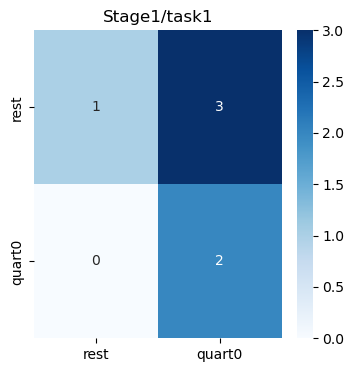


=== Stage 2: quartile 1 vs rest ===
  Epoch 01, loss_new: 0.7722
  Epoch 10, loss_new: 0.7733
  Epoch 50, loss_new: 0.6711
  → Acc task1 after stage2: 83.33%


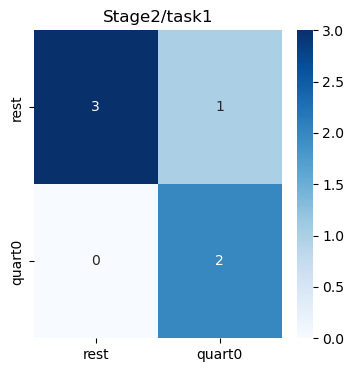

  → Acc task2 after stage2: 80.00%


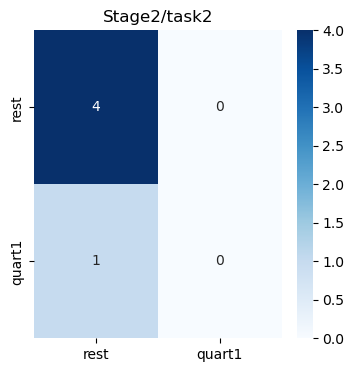


=== Stage 3: quartile 2 vs rest ===
  Epoch 01, loss_new: 0.6649
  Epoch 10, loss_new: 0.6690
  Epoch 50, loss_new: 0.6710
  → Acc task1 after stage3: 100.00%


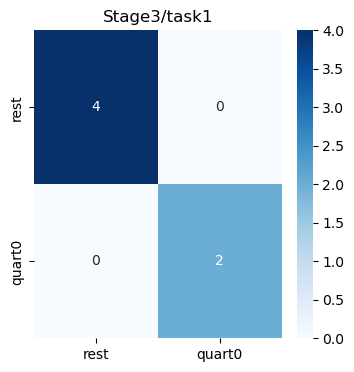

  → Acc task2 after stage3: 80.00%


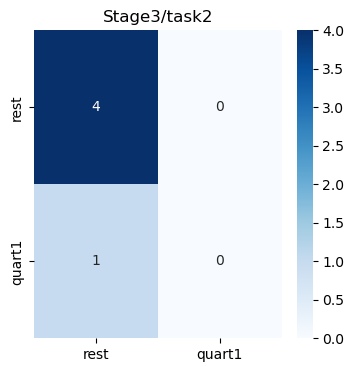

  → Acc task3 after stage3: 66.67%


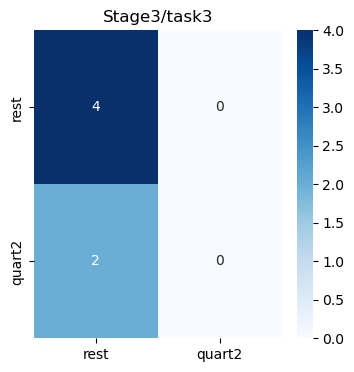


=== Stage 4: quartile 3 vs rest ===
  Epoch 01, loss_new: 0.7045
  Epoch 10, loss_new: 0.6872
  Epoch 50, loss_new: 0.6927
  → Acc task1 after stage4: 66.67%


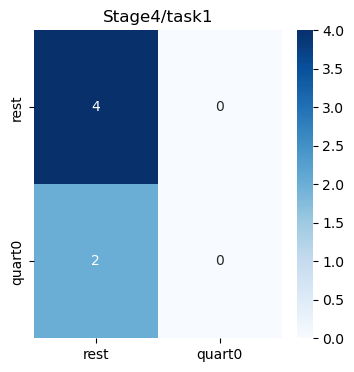

  → Acc task2 after stage4: 80.00%


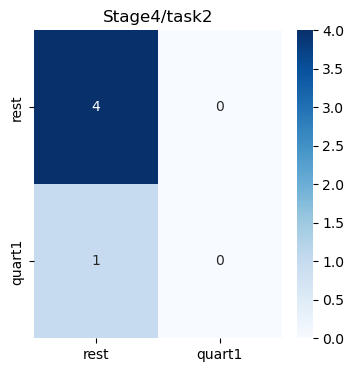

  → Acc task3 after stage4: 66.67%


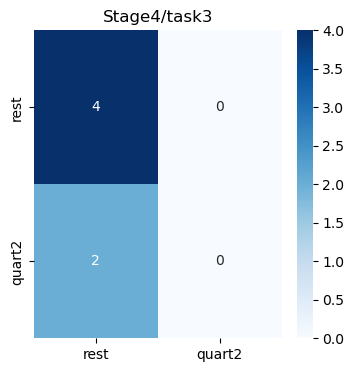

  → Acc task4 after stage4: 66.67%


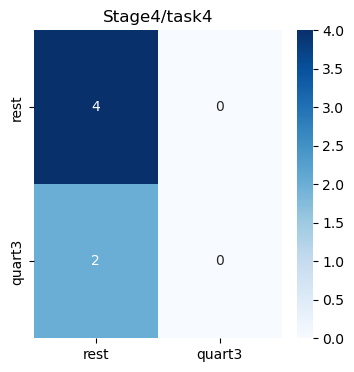


=== Accuracies per stage & task ===
        task_1  task_2  task_3  task_4
Stage                                 
1       50.00%    nan%    nan%    nan%
2       83.33%  80.00%    nan%    nan%
3      100.00%  80.00%  66.67%    nan%
4       66.67%  80.00%  66.67%  66.67%

=== A-GEM Dashboard: Drift vs Forgetting ===
  from_to  param_drift  delta_acc
0     1→2     0.015026  -0.333333
1     1→3     0.047044  -0.500000
2     2→3     0.037385   0.000000
3     1→4     0.077218  -0.166667
4     2→4     0.068202   0.000000
5     3→4     0.030860   0.000000

Corr(param_drift vs ΔAcc): 0.1849


In [13]:
import random
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess CSV
# ------------------------------------------------
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# ------------------------------------------------
# 2. Build one DGLGraph per circuit_id
# ------------------------------------------------
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges: 
        continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)),
                  num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values,
                                   dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# ------------------------------------------------
# 3. Define 4 binary quartile tasks
# ------------------------------------------------
qs = np.percentile(sizes, [25,50,75])
quarts = np.digitize(sizes, qs)   # 0..3

tasks = []
for q in range(4):
    pos = np.where(quarts==q)[0]
    neg = np.where(quarts!=q)[0]
    if len(pos)<5:
        continue
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    tasks.append({
        "q": q,
        "train_pos": p_tr.tolist(), "train_neg": n_tr.tolist(),
        "test_pos":  p_te.tolist(), "test_neg":  n_te.tolist()
    })

# ------------------------------------------------
# 4. GCN encoder + readout
# ------------------------------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   hid,   allow_zero_in_degree=True)
        self.read  = nn.Linear(hid, 2)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        h = torch.relu(self.conv2(g, h))
        hg = h.mean(dim=0, keepdim=True)
        return self.read(hg)

# ------------------------------------------------
# 5. MER hyperparams
# ------------------------------------------------
inner_lr        = 0.005
meta_lr         = 0.01
memory_per_task = 200
mer_batch_size  = 64

# ------------------------------------------------
# 6. Training loop w/ MER
# ------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCNEnc(len(feat_cols), 64).to(device)
opt    = optim.SGD(model.parameters(), lr=meta_lr)
criterion = nn.CrossEntropyLoss()

memory_buffer   = []   # stored graph indices
memory_snapshots= []
param_snapshots = []
results         = {}
logits_snapshots= []

for stage, t in enumerate(tasks, start=1):
    q       = t["q"]
    p_tr, n_tr = t["train_pos"], t["train_neg"]
    p_te, n_te = t["test_pos"],  t["test_neg"]
    new_idxs   = p_tr + n_tr

    print(f"\n=== Stage {stage}: quartile {q} vs rest ===")
    model.train()
    for epoch in (1,10,50):
        # --- sample batches ---
        new_batch = random.sample(new_idxs, 
                                  min(mer_batch_size, len(new_idxs)))
        if len(memory_buffer)>=mer_batch_size:
            mem_batch = random.sample(memory_buffer, mer_batch_size)
        else:
            mem_batch = memory_buffer.copy()

        # 1) grad on new batch
        logits_new=[]
        for i in new_batch:
            g = graphs[i].to(device)
            logits_new.append(model(g, g.ndata["feat"].to(device))[0])
        logits_new = torch.stack(logits_new)
        y_new = torch.tensor(
            [1]*len(p_tr if q in range(4) else []) + [0]*len(n_tr),
            dtype=torch.long, device=device
        )
        loss_new = criterion(logits_new, y_new)
        grads_new = torch.autograd.grad(loss_new, model.parameters(),
                                        create_graph=True)

        # 2) inner update
        backup = [p.data.clone() for p in model.parameters()]
        for p, gnew in zip(model.parameters(), grads_new):
            p.data.sub_(inner_lr * gnew.data)

        # 3) grad on mem batch
        if mem_batch:
            logits_mem=[]
            for i in mem_batch:
                g = graphs[i].to(device)
                logits_mem.append(model(g, g.ndata["feat"].to(device))[0])
            logits_mem = torch.stack(logits_mem)
            # labels: we know exemplar origin was p_tr or n_tr
            y_mem = []
            for i in mem_batch:
                y_mem.append(1 if i in p_tr else 0)
            y_mem = torch.tensor(y_mem, dtype=torch.long, device=device)
            loss_mem = criterion(logits_mem, y_mem)
            grads_meta = torch.autograd.grad(loss_mem, model.parameters())
        else:
            grads_meta = grads_new

        # 4) restore & meta-step
        for p, b in zip(model.parameters(), backup):
            p.data.copy_(b)
        opt.zero_grad()
        for p, gm in zip(model.parameters(), grads_meta):
            p.grad = gm.data.clone()
        opt.step()

        print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory
    sampled = random.sample(new_idxs, 
                            min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)
    memory_snapshots.append(list(memory_buffer))

    # snapshot params & logits
    param_snapshots.append({
        n: v.clone().detach().cpu()
        for n,v in model.state_dict().items()
    })
    with torch.no_grad():
        all_logits=[]
        for g in graphs:
            g = g.to(device)
            all_logits.append(model(g, g.ndata["feat"].to(device))[0].cpu().numpy())
    logits_snapshots.append(np.vstack(all_logits))

    # evaluate on all seen tasks
    model.eval()
    preds = logits_snapshots[-1].argmax(axis=1)
    results[stage] = {}
    for k in range(stage):
        pp = tasks[k]["test_pos"]; nnk = tasks[k]["test_neg"]
        idxs = pp + nnk
        y_true = np.array([1]*len(pp)+[0]*len(nnk))
        y_pred = preds[idxs]
        acc = accuracy_score(y_true, y_pred)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1} after stage{stage}: {acc*100:.2f}%")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["rest",f"quart{tasks[k]['q']}"],
                    yticklabels=["rest",f"quart{tasks[k]['q']}"])
        plt.title(f"Stage{stage}/task{k+1}")
        plt.show()

# ------------------------------------------------
# 7. Summary table
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Accuracies per stage & task ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# ------------------------------------------------
# 8. Interpretability Dashboard
# ------------------------------------------------
import pandas as _pd

records = []
for t in range(2, len(param_snapshots)+1):
    θ_t = param_snapshots[t-1]
    for k in range(1, t):
        θ_k = param_snapshots[k-1]
        # param drift
        sq = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd_ = np.sqrt(sq)
        # cosine sim of meta-grad? skip – use param drift only
        da  = results[k][f"task_{k}"] - results[t][f"task_{k}"]
        records.append({
            "from_task": k, "to_task": t,
            "param_drift": pd_, "delta_acc": da
        })

dash = _pd.DataFrame(records)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)
print("\n=== A-GEM Dashboard: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","delta_acc"]])
print(f"\nCorr(param_drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")


#### Hybrid: CoPE
- Combines continual learning with self-supervised pretraining.

Global self‐supervised pretraining...
  Ep 1/30, avg pre‐loss: 4.4170
  Ep 15/30, avg pre‐loss: 3.4288
  Ep 30/30, avg pre‐loss: 1.9530

=== Stage 1: CoPE quartile 0 vs rest ===
  [Pre1] Ep 1/30, avg pre‐loss: 7.1397
  [Pre1] Ep 15/30, avg pre‐loss: 0.5498
  [Pre1] Ep 30/30, avg pre‐loss: 1.3528
  [Cls1] Ep 1/40, cls‐loss: 0.6380
  [Cls1] Ep 20/40, cls‐loss: 0.4897
  [Cls1] Ep 40/40, cls‐loss: 0.2397
  → Acc task1: 66.67%


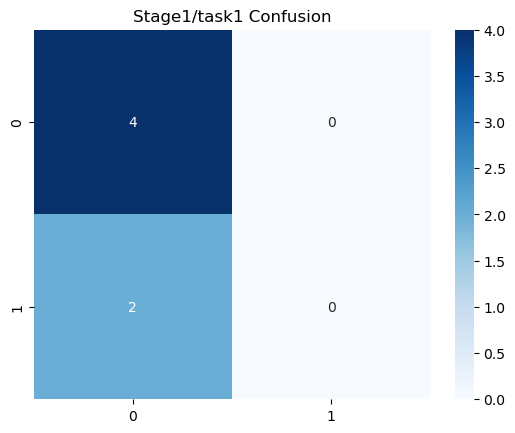


=== Stage 2: CoPE quartile 1 vs rest ===
  [Pre2] Ep 1/30, avg pre‐loss: 62.6513
  [Pre2] Ep 15/30, avg pre‐loss: 3.7090
  [Pre2] Ep 30/30, avg pre‐loss: 9.9175
  [Cls2] Ep 1/40, cls‐loss: 0.5892
  [Cls2] Ep 20/40, cls‐loss: 0.0360
  [Cls2] Ep 40/40, cls‐loss: 0.0007
  → Acc task1: 33.33%


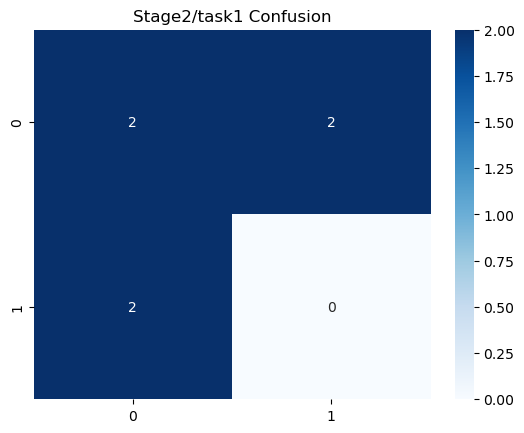

  → Acc task2: 60.00%


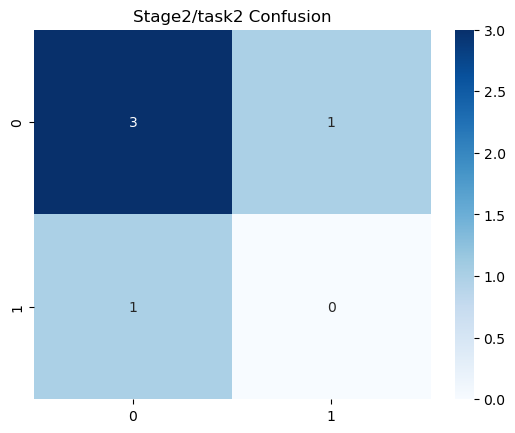


=== Stage 3: CoPE quartile 2 vs rest ===
  [Pre3] Ep 1/30, avg pre‐loss: 6.0497
  [Pre3] Ep 15/30, avg pre‐loss: 18.6574
  [Pre3] Ep 30/30, avg pre‐loss: 7.6936
  [Cls3] Ep 1/40, cls‐loss: 2.2727
  [Cls3] Ep 20/40, cls‐loss: 0.1836
  [Cls3] Ep 40/40, cls‐loss: 0.0639
  → Acc task1: 66.67%


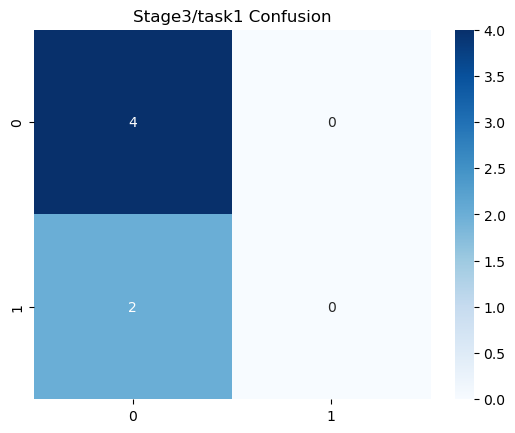

  → Acc task2: 60.00%


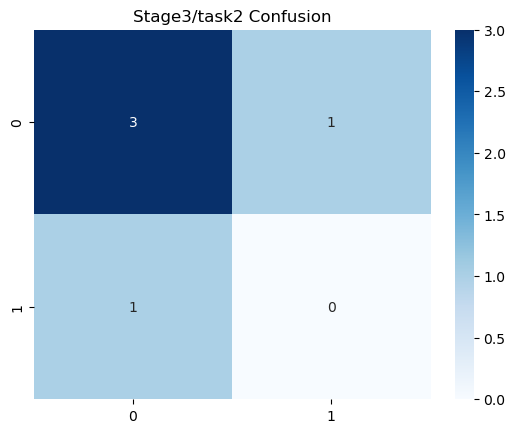

  → Acc task3: 66.67%


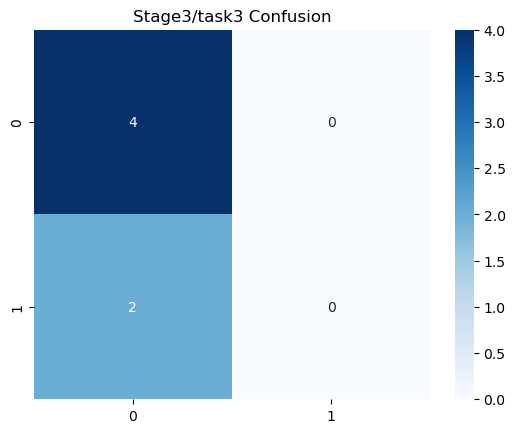


=== Stage 4: CoPE quartile 3 vs rest ===
  [Pre4] Ep 1/30, avg pre‐loss: 117.1138
  [Pre4] Ep 15/30, avg pre‐loss: 8.6005
  [Pre4] Ep 30/30, avg pre‐loss: 59.2808
  [Cls4] Ep 1/40, cls‐loss: 1.7553
  [Cls4] Ep 20/40, cls‐loss: 0.3151
  [Cls4] Ep 40/40, cls‐loss: 0.1598
  → Acc task1: 33.33%


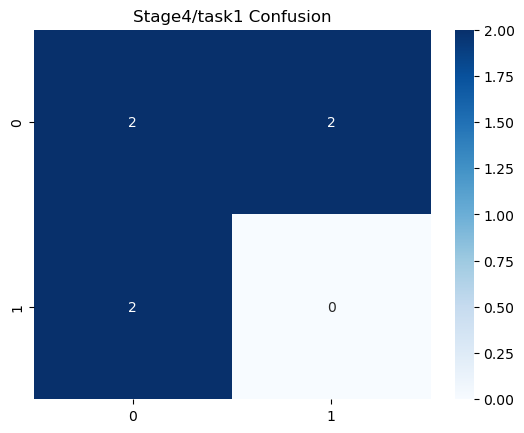

  → Acc task2: 40.00%


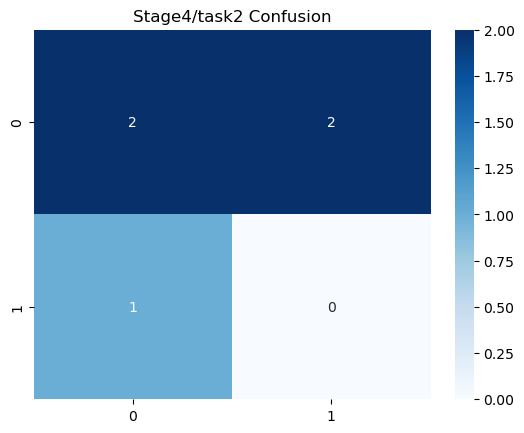

  → Acc task3: 50.00%


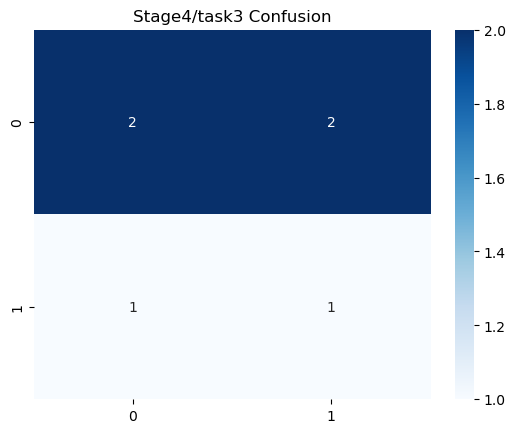

  → Acc task4: 83.33%


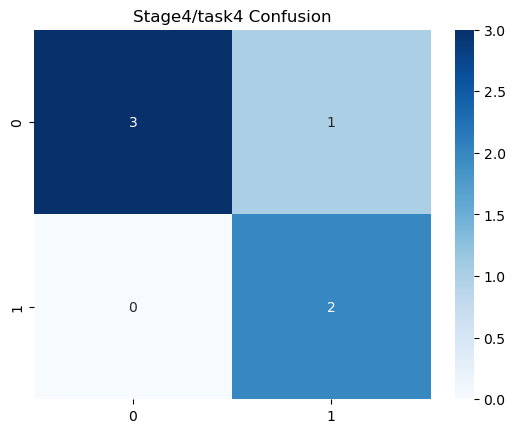


=== Test accuracies per stage & task ===
       task_1  task_2  task_3  task_4
Stage                                
1      66.67%    nan%    nan%    nan%
2      33.33%  60.00%    nan%    nan%
3      66.67%  60.00%  66.67%    nan%
4      33.33%  40.00%  50.00%  83.33%


AttributeError: 'numpy.float64' object has no attribute 'DataFrame'

In [14]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------
# 1. Load & preprocess node‐feature CSV
# ---------------------------------------
df = pd.read_csv("all_circuits_features_graphclass.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols])

# ---------------------------------------
# 2. Build one DGLGraph per circuit_id
# ---------------------------------------
graphs, sizes = [], []
for cid, sub in df.groupby("circuit_id"):
    nodes = sub["node"].tolist()
    idx   = {n:i for i,n in enumerate(nodes)}
    edges = set()
    for _,r in sub.iterrows():
        u = idx[r["node"]]
        k = int(r["fan_in"])
        for p in nodes[:k]:
            edges.add((idx[p], u))
    if not edges:
        continue
    src, dst = zip(*edges)
    g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=len(nodes))
    g = dgl.add_self_loop(g)
    g.ndata["feat"] = torch.tensor(sub[feat_cols].values, dtype=torch.float32)
    graphs.append(g)
    sizes.append(len(nodes))

graphs = np.array(graphs)
sizes  = np.array(sizes)

# ---------------------------------------
# 3. Define 4 binary tasks by quartile
# ---------------------------------------
qs    = np.percentile(sizes, [25,50,75])
quarts= np.digitize(sizes, qs)   # 0..3

tasks = []
for q in range(4):
    pos = np.where(quarts==q)[0].tolist()
    neg = np.where(quarts!=q)[0].tolist()
    if len(pos)<5:
        continue
    p_tr, p_te = train_test_split(pos, test_size=0.2, random_state=42)
    n_tr, n_te = train_test_split(neg, test_size=0.2, random_state=42)
    tasks.append({
        "q": q,
        "train_pos": p_tr, "train_neg": n_tr,
        "test_pos":  p_te, "test_neg":  n_te
    })

# ---------------------------------------
# 4. CoPEModel: GCN + pretext head + classifier
# ---------------------------------------
class CoPEModel(nn.Module):
    def __init__(self, in_feats, hid, drop=0.5):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.bn1   = nn.BatchNorm1d(hid)
        self.conv2 = dglnn.GraphConv(hid, hid, allow_zero_in_degree=True)
        self.bn2   = nn.BatchNorm1d(hid)
        self.drop  = nn.Dropout(drop)
        self.pre   = nn.Linear(hid, in_feats)
        self.cls   = nn.Linear(hid, 2)

    def encode(self, g, x):
        h = F.relu(self.bn1(self.conv1(g, x)))
        h = self.drop(h)
        h = F.relu(self.bn2(self.conv2(g, h)))
        return self.drop(h)

    def reconstruct(self, g, x):
        h = self.encode(g, x)
        return self.pre(h)

    def forward(self, g, x):
        h  = self.encode(g, x)
        hg = h.mean(dim=0, keepdim=True)
        return self.cls(hg)

# ---------------------------------------
# 5. Hyperparameters & optimizers
# ---------------------------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model      = CoPEModel(len(feat_cols), hid=64, drop=0.4).to(device)
opt_pre    = optim.Adam(
    list(model.conv1.parameters())+list(model.bn1.parameters())+
    list(model.conv2.parameters())+list(model.bn2.parameters())+
    list(model.pre.parameters()),
    lr=5e-4, weight_decay=1e-5
)
opt_cls    = optim.Adam(
    list(model.conv1.parameters())+list(model.bn1.parameters())+
    list(model.conv2.parameters())+list(model.bn2.parameters())+
    list(model.cls.parameters()),
    lr=5e-3, weight_decay=1e-5
)
mask_ratio = 0.2
pre_epochs = 30
cls_epochs = 40

# ---------------------------------------
# 6. Global self‐supervised warm‐up
# ---------------------------------------
print("Global self‐supervised pretraining...")
for ep in range(1, pre_epochs+1):
    total_loss = 0
    for g in graphs:
        g = g.to(device)
        x = g.ndata["feat"]
        dims = np.random.choice(x.shape[1], int(mask_ratio*x.shape[1]), replace=False)
        xm   = x.clone(); xm[:,dims] = 0
        recon= model.reconstruct(g, xm)
        loss = F.mse_loss(recon[:,dims], x[:,dims])
        opt_pre.zero_grad(); loss.backward(); opt_pre.step()
        total_loss += loss.item()
    if ep in (1, pre_epochs//2, pre_epochs):
        print(f"  Ep {ep}/{pre_epochs}, avg pre‐loss: {total_loss/len(graphs):.4f}")

# ---------------------------------------
# 7. Stage‐wise CoPE training & eval
# ---------------------------------------
results = {}
param_snaps   = []
pretext_snaps = []

for stage, t in enumerate(tasks, start=1):
    q      = t["q"]
    p_tr, n_tr = t["train_pos"], t["train_neg"]
    p_te, n_te = t["test_pos"],  t["test_neg"]
    tr_idxs    = p_tr + n_tr
    te_idxs    = p_te + n_te

    print(f"\n=== Stage {stage}: CoPE quartile {q} vs rest ===")

    # (a) Task‐specific self‐supervised pretrain
    for ep in range(1, pre_epochs+1):
        total_loss = 0
        for i in tr_idxs:
            g = graphs[i].to(device)
            x = g.ndata["feat"]
            dims = np.random.choice(x.shape[1], int(mask_ratio*x.shape[1]), replace=False)
            xm   = x.clone(); xm[:,dims]=0
            recon= model.reconstruct(g, xm)
            loss = F.mse_loss(recon[:,dims], x[:,dims])
            opt_pre.zero_grad(); loss.backward(); opt_pre.step()
            total_loss += loss.item()
        if ep in (1, pre_epochs//2, pre_epochs):
            print(f"  [Pre{stage}] Ep {ep}/{pre_epochs}, avg pre‐loss: {total_loss/len(tr_idxs):.4f}")

    # (b) Supervised fine‐tune
    y_tr = torch.tensor([1]*len(p_tr)+[0]*len(n_tr),
                        dtype=torch.long, device=device)
    for ep in range(1, cls_epochs+1):
        outs=[]
        for i in tr_idxs:
            g = graphs[i].to(device)
            outs.append(model(g, g.ndata["feat"].to(device))[0])
        outs = torch.stack(outs)
        loss = nn.CrossEntropyLoss()(outs, y_tr)
        opt_cls.zero_grad(); loss.backward(); opt_cls.step()
        if ep in (1, cls_epochs//2, cls_epochs):
            print(f"  [Cls{stage}] Ep {ep}/{cls_epochs}, cls‐loss: {loss.item():.4f}")

    # snapshots
    param_snaps.append({n:p.clone().cpu()
                        for n,p in model.state_dict().items()})
    pretext_snaps.append({n:p.clone().cpu()
                          for n,p in model.pre.state_dict().items()})

    # evaluate on all seen tasks
    model.eval()
    preds = []
    with torch.no_grad():
        for g in graphs:
            g = g.to(device)
            preds.append(model(g, g.ndata["feat"].to(device))[0].cpu().numpy())
    preds = np.stack(preds).argmax(axis=1)

    results[stage] = {}
    for k in range(stage):
        tp = tasks[k]["test_pos"]; tn = tasks[k]["test_neg"]
        idxs = tp + tn
        y_true = np.array([1]*len(tp)+[0]*len(tn))
        y_pred = preds[idxs]
        acc    = accuracy_score(y_true, y_pred)
        results[stage][f"task_{k+1}"] = acc
        print(f"  → Acc task{k+1}: {acc*100:.2f}%")
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Stage{stage}/task{k+1} Confusion"); plt.show()

# ---------------------------------------
# 8. Results summary
# ---------------------------------------
df_res = pd.DataFrame(results).T; df_res.index.name="Stage"
print("\n=== Test accuracies per stage & task ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# ---------------------------------------
# 9. Interpretability Dashboard
# ---------------------------------------
records = []
for t in range(2, len(param_snaps)+1):
    θ_t = param_snaps[t-1]
    for k in range(1, t):
        θ_k = param_snaps[k-1]
        # 1) param drift
        pd2 = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd  = np.sqrt(pd2)
        # 2) CoPE‐shift: pretext‐head drift
        ph_t = pretext_snaps[t-1]; ph_k = pretext_snaps[k-1]
        ss   = sum((ph_t[n]-ph_k[n]).pow(2).sum().item() for n in ph_k)
        shift = np.sqrt(ss)
        # 3) forgetting
        da = results[k][f"task_{k}"] - results[t][f"task_{k}"]
        records.append({
            "from_task": k, "to_task": t,
            "param_drift": pd,
            "cope_shift":  shift,
            "delta_acc":   da
        })

dash = pd.DataFrame(records)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)
print("\n=== CoPE Interpretability: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","cope_shift","delta_acc"]])
print(f"\nCorr(param_drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
print(f"Corr(CoPE_shift vs ΔAcc): {dash.cope_shift.corr(dash.delta_acc):.4f}")


In [15]:
# -----------------------------
# CoPE Interpretability Dashboard (fixed)
# -----------------------------
import pandas as _pd

# Ensure records is a list
if not isinstance(records, list):
    raise RuntimeError(f"records must be a list, got {type(records)}")

# Build DataFrame
dash = _pd.DataFrame.from_records(records)

if dash.empty:
    print("Not enough data for CoPE dashboard.")
else:
    dash["from_to"] = (
        dash["from_task"].astype(int).astype(str)
        + "→"
        + dash["to_task"].astype(int).astype(str)
    )
    print("\n=== CoPE Interpretability: Drift vs Forgetting ===")
    print(dash[["from_to","param_drift","cope_shift","delta_acc"]])
    print(f"\nCorr(param_drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
    print(f"Corr(CoPE_shift vs ΔAcc):  {dash.cope_shift.corr(dash.delta_acc):.4f}")



=== CoPE Interpretability: Drift vs Forgetting ===
  from_to  param_drift  cope_shift  delta_acc
0     1→2     5.262125    0.500679   0.333333
1     1→3     6.789781    0.706511   0.000000
2     2→3     5.925833    0.491760   0.000000
3     1→4     7.381820    0.801193   0.333333
4     2→4     6.967100    0.621501   0.200000
5     3→4     4.392001    0.308419   0.166667

Corr(param_drift vs ΔAcc): 0.0191
Corr(CoPE_shift vs ΔAcc):  0.1441
